In [348]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [349]:
import plotly
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
from ast import literal_eval

from scipy.stats.stats import pearsonr
import itertools

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

from sklearn import preprocessing

# импортируем библиотеку обработки текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

/tmp/ipykernel_32/866889126.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [350]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [351]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/tmp/ipykernel_32/3925405557.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [352]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Первоначальные признаки датасета:  

**hotel_address** — адрес отеля;  
**review_date** — дата, когда рецензент разместил соответствующий отзыв;  
**average_score** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;  
**hotel_name** — название отеля;  
**reviewer_nationality** — страна рецензента;  
**negative_review** — отрицательный отзыв, который рецензент дал отелю;  
**review_total_negative_word_counts** — общее количество слов в отрицательном отзыв;  
**positive_review** — положительный отзыв, который рецензент дал отелю;  
**review_total_positive_word_counts** — общее количество слов в положительном отзыве.  
**reviewer_score** — оценка, которую рецензент поставил отелю на основе своего опыта;  
**total_number_of_reviews_reviewer_has_given** — количество отзывов, которые рецензенты дали в прошлом;  
**total_number_of_reviews** — общее количество действительных отзывов об отеле;  
**tags** — теги, которые рецензент дал отелю;  
**days_since_review** — количество дней между датой проверки и датой очистки;  
**additional_number_of_scoring** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.  
**lat** — географическая широта отеля;  
**lng** — географическая долгота отеля.  

Пропуски есть только в 2х признаках - широте и долготе отелей. Заполним их, но предварительно разметим какие данные были пропущены.

In [353]:
df = hotels.copy()

In [354]:
cols_with_missing = ['lng']                          # т.к. в обоих колонках пропуски в одинаковых местах, сделаем разметку только по 1 столбцу

for col in cols_with_missing:
    df[col + '_was_missing'] = df[col].isna()
    
df['lng_was_missing'] = np.where((df['lng_was_missing'] == True), 1, 0)

In [355]:
coor_df= df[['hotel_address', 'lat', 'lng']]
# словарь с координатами отелей
hotel_coordinates = coor_df.groupby('hotel_address')['lat', 'lng'].first().to_dict()

# словарь с координатами отелей с карт
hotel_lat = {'20 Rue De La Ga t 14th arr 75014 Paris France': 48.827845,
  '23 Rue Damr mont 18th arr 75018 Paris France': 48.886363,
  '4 rue de la P pini re 8th arr 75008 Paris France': 48.868109,
  'Bail n 4 6 Eixample 08010 Barcelona Spain': 41.390955,
  'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 48.222980,
  'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 48.779481,
  'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 48.210918,
  'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 48.210834,
  'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 48.19288089795001,
  'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 48.16637426860036,
  'Pau Clar s 122 Eixample 08009 Barcelona Spain': 41.39287199168932,
  'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 48.21969804202635,
  'Sep lveda 180 Eixample 08011 Barcelona Spain': 41.40156839291513,
  'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 48.246253876270494,
  'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 48.21363741266167,
  'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 48.226431942000715,
  'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 48.22620322382607}
 
hotel_lng = {'20 Rue De La Ga t 14th arr 75014 Paris France': 2.321028,
  '23 Rue Damr mont 18th arr 75018 Paris France': 2.349278,
  '4 rue de la P pini re 8th arr 75008 Paris France': 2.360294,
  'Bail n 4 6 Eixample 08010 Barcelona Spain': 2.155579,
  'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 16.357630,
  'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 15.657069,
  'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 16.347119,
  'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 16.347110,
  'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 16.401198146858796,
  'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 16.445599235618207,
  'Pau Clar s 122 Eixample 08009 Barcelona Spain': 2.1671877389652274,
  'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 16.285581368183013,
  'Sep lveda 180 Eixample 08011 Barcelona Spain': 2.1350468077126257,
  'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 16.34184552954927,
  'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 16.38012185469133,
  'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 16.356993686635533,
  'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 16.356822025255575}

# заполним пропущенные значения
df['lat_new'] = df.hotel_address.map(hotel_lat)                               # вспомогательный столбец
df['lat'] = np.where((df['lat'].isnull()), df['lat_new'], df['lat'])  # заполнение пропусков

df['lng_new'] = df.hotel_address.map(hotel_lng)
df['lng'] = np.where((df['lng'].isnull()), df['lng_new'], df['lng'])

df.drop(['lat_new', 'lng_new'], axis = 1, inplace = True) # удаляем вспомогательные столбцы

/tmp/ipykernel_32/1425893375.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hotel_coordinates = coor_df.groupby('hotel_address')['lat', 'lng'].first().to_dict()


In [356]:
len(df[df.duplicated()])

336

В данных 336 дублирующих строк, но по условиям соревнования удалять их нельзя, а разметка только ухудшает метрику, по-этому пока их не трогаем.

### review_date

Приведем признак в формат даты и обогатим датасет новыми признаками (создание признака года ухудшило метрику)

In [357]:
df['review_date'] = pd.to_datetime(df['review_date'])

df['review_month'] = df['review_date'].dt.month
df['review_day_of_wk'] = df['review_date'].dt.dayofweek
df['is_weekend'] = df['review_day_of_wk'].apply(lambda x: 1 if x >= 5 else 0)
df['quarter'] = df['review_date'].dt.quarter

### tags

Выделим из тегов количество ночей проживания.

In [358]:
df['temporal'] = df['tags'].apply(lambda x: literal_eval(x)) # преобразуем строки в списки тегов
df['temporal'] = df['temporal'].explode(ignore_index=True)   # разобьем на отдельные теги


'''функция, которая выбирает из тегов количество ночей'''

def num_nights(tag):
    tag = tag.split(' ')
    if 'Stayed' in tag:
        return tag[-3]
    elif 'nights'  in tag:
        return tag[-4]
    else:
        return 0
    
df1 = df.copy()
df1['nights'] = 0
df1['nights'] = df1['temporal'].apply(num_nights)            # добавим столбец с количеством ночей

df1['nights'] = df1['nights'].astype('int')                  # преобразуем в число

### days_since_review

преобразуем признак в числовой формат

In [359]:
df2 = df1.copy()

'''Функция которая оставляет только первый элемент списка'''

def num_days(col):
    col = col.split(' ')
    return col[0]

df2['days_since_review_new'] = 0
df2['days_since_review_new'] = df2['days_since_review'].apply(num_days)
df2['days_since_review_new'] = df2['days_since_review_new'].astype(int)

### hotel_address

Выделим города из адреса отеля.  
Поскольку для всех адресов, кроме UK, присуща одинаковая структура - возьмем предпоследний элемент.

In [360]:
df2['city'] = df2.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])

Обогатим датасет данными о населении городов (словарь из открытого источника).

In [361]:
Population = {'Amsterdam': 921468,
               'Barcelona' : 1636193,
               'London': 9002488,
               'Milan' : 1366180,
               'Paris' : 2226621,
               'Vienna' : 1973403}

df2['city'] = df2.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
df2['population'] = df2.city.map(Population)

Создадим бинарные признаки по городам

In [362]:
df2 = pd.get_dummies(df2, columns=['city'])

### positive_review, negative_review

выделим количество позитивных и негативных слов из отзывов

In [363]:
df3 = df2.copy()
# слова в отзывах 
def num_words(scroll):
    
    i = 0
    for word in scroll:
        for mood in key_words:
            if mood == word.lower():
                i += 1
    return i

key_words = ['good','great','nice','best','excellent','but','delicious', 'friendly', 'lovely', 'amazing', 'tasty', 'friendly', 'comfortable', 'wonderful', 'beautiful', 'super', 
             'brilliant', 'perfectly', 'liked', 'helpful', 'comfy', 'lovely', 'convenient']

df3['words'] = df3.positive_review.str.findall(r"(\w+)")
df3['review_mood_good'] = df3.words.dropna().apply(num_words)

key_words = ['bed','no','lounge','noise','useless','old','badly', 'cracked', 'broken', 'worn', 'tired', 'little', 'issues', 'tight', 'unimpressive', 'dark', 'faulty', 'inconvenient', 'damage',
            'wrong', 'extremely', 'short', 'lilliputian', 'unable', 'nuisance', 'expectations']

df3['words_'] = df3.negative_review.str.findall(r"(\w+)")
df3['review_mood_bed'] = df3.words_.dropna().apply(num_words)

In [364]:
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

# С помощью SentimentIntensityAnalyzer оценим отзывы по категориям: neg, pos, compound
df3['neg_neg'] = df3['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
df3['pos_neg'] = df3['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
df3['compound_neg'] = df3['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

# Так же с поситивными отзывами
df3['neg_pos'] = df3['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
df3['pos_pos'] = df3['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
df3['compound_pos'] = df3['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Корреляция

In [365]:
object_columns = [s for s in df3.columns if df3[s].dtypes == 'object' ]
df3.drop(object_columns, axis = 1, inplace=True)
df3.drop('review_date', axis = 1, inplace=True)

correlations = {}
columns = df3.columns.tolist()                                                           # список признаков

for col_a, col_b in itertools.combinations(columns, 2):                                  # уникальные комбинации столбцов 
    correlations[col_a + '__' + col_b] = pearsonr(df3.loc[:, col_a], df3.loc[:, col_b])  # парные корреляции, используя scipy.stats.stats.personr

result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value']

result[(result['PCC'] > 0.7) | (result['PCC'] < -0.7)]

,PCC,p-value
additional_number_of_scoring__total_number_of_reviews,0.824884,0.0
lat__city_Barcelona,-0.844623,0.0
lng__city_Vienna,0.824900,0.0
sample__reviewer_score,0.931753,0.0
review_month__quarter,0.969874,0.0
review_day_of_wk__is_weekend,0.830935,0.0
population__city_London,0.995944,0.0
neg_neg__compound_neg,-0.739397,0.0


Корреляция показала тесную связь между 8 парами признаков.

In [366]:
# удалим некоторые признаки из пар с высокой корреляцией

df3.drop('city_Vienna', axis = 1, inplace=True)

In [367]:
df3.drop('city_London', axis = 1, inplace=True)

Удаление других признаков, не смотря на тесную связь, не дало улучшение метрики.  
Нормализация и стандартизация всех признаков не привели к улудшению значения метрики.

In [368]:
df4 = df3.copy()

In [369]:
# Добавим странных признаков

df4['some_1'] = df4['review_total_negative_word_counts'] - df4['review_total_positive_word_counts']

In [372]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [373]:
# Теперь выделим тестовую часть
train_data = df4.query('sample == 1').drop(['sample'], axis=1)
test_data = df4.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [374]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [375]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 30), (386803, 30), (386803, 29), (309442, 29), (77361, 29))

In [376]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [377]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [378]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
def MAPE(y_test, y_pred): 
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test))*100
print('MAPE:', (MAPE(y_test, y_pred)))

MAPE: 12.566087685771299


<Axes: >

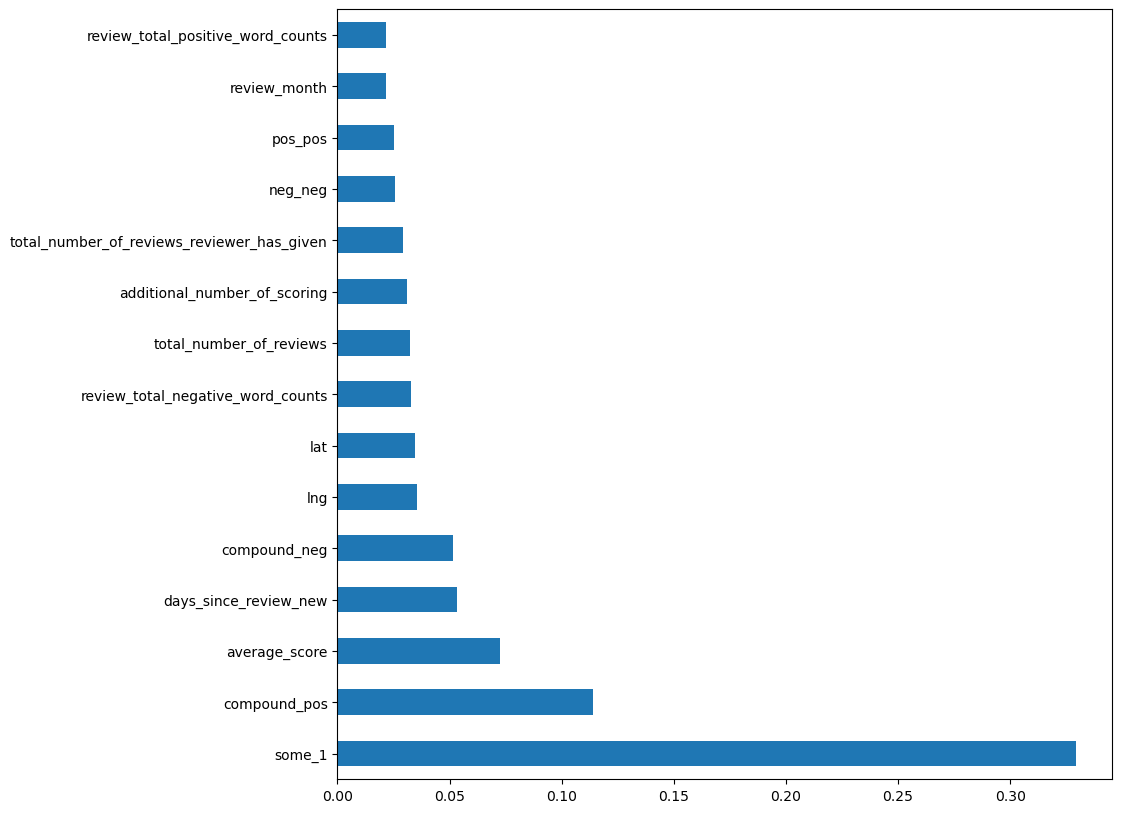

In [379]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [380]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,lng_was_missing,...,city_Paris,review_mood_good,review_mood_bed,neg_neg,pos_neg,compound_neg,neg_pos,pos_pos,compound_pos,some_1
80513,360,8.3,12,1181,0,1,51.475172,-0.187063,0.0,0,...,0,0,0,0.000,0.000,0.0000,0.379,0.621,0.3400,12
69806,531,9.0,0,2298,11,2,51.512196,-0.131838,0.0,0,...,0,0,1,1.000,0.000,-0.7096,0.223,0.281,0.1779,-11
60045,914,8.5,2,7586,2,8,52.385601,4.847060,0.0,0,...,0,0,0,0.000,0.000,0.0000,0.000,0.000,0.0000,0
2808,685,8.6,18,2277,6,4,51.532251,-0.109571,0.0,0,...,0,1,0,0.000,0.000,0.0000,0.000,0.000,0.0000,12
17543,391,8.6,6,2685,8,1,51.490105,-0.138135,0.0,0,...,0,2,0,0.000,0.000,0.0000,0.000,0.643,0.8016,-2
23434,40,8.8,7,221,4,8,48.845279,2.342295,0.0,0,...,1,0,0,0.000,0.000,0.0000,0.000,0.000,0.0000,3
54486,194,8.4,0,1431,8,1,48.855312,2.325463,0.0,0,...,1,1,1,1.000,0.000,-0.7096,0.000,0.600,0.7184,-8
119383,152,9.0,34,1682,11,61,48.832876,2.357253,0.0,0,...,1,4,1,0.138,0.091,-0.1779,0.000,0.640,0.8923,23
41794,488,8.2,42,4645,6,3,41.411165,2.219201,0.0,0,...,0,1,2,0.184,0.105,-0.3950,0.000,0.000,0.0000,36
76359,688,7.8,3,2147,3,2,51.531979,-0.061598,0.0,0,...,0,1,0,0.756,0.000,-0.4767,0.000,0.737,0.4215,0


In [381]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [382]:
len(sample_submission)

128935

In [383]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


In [384]:
len(predict_submission)

128935

In [385]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.646,488440
1,7.273,274649
2,8.659,374688
3,9.761,404352
4,9.534,451596
5,8.881,302161
6,7.659,317079
7,7.719,13963
8,8.031,159785
9,7.124,195089
